<a href="https://colab.research.google.com/github/DinisMartinho/Image-Colorizer/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****Image Colorizer****
----

**Credits:** Dinis Caçador Martinho **( 08/10/2022 )**

[✗] ( https://github.com/DinisMartinho )

In [1]:
import torch, torchvision
from tqdm import tqdm

In [2]:
# GPU is preferable for complex training.
use_collab_gpu = True #@param {type:"boolean"}

In [3]:
if use_collab_gpu == True:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

In [4]:
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # Neural Network Layers
    self.input_to_hidden = torch.nn.Conv2d(in_channels=1, out_channels=12,
                                           kernel_size=(3,3), stride=(1,1), padding=1)
    
    self.hidden_to_latent = torch.nn.Conv2d(in_channels=12, out_channels=12,
                                            kernel_size=(3,3), stride=(1,1), padding=1)
    
    self.latent_to_hidden = torch.nn.Conv2d(in_channels=12, out_channels=12,
                                            kernel_size=(3,3), stride=(1,1), padding=1)
    
    self.hidden_to_output = torch.nn.Conv2d(in_channels=12, out_channels=3,
                                            kernel_size=(3,3), stride=(1,1), padding=1)    
    
    # Cellulite 
    self.hidden_to_hidden = torch.nn.Conv2d(in_channels=12, out_channels=12,
                                            kernel_size=(3,3), stride=(1,1), padding=1)    
    
    # Activation Functions
    self.relu = torch.nn.ReLU(inplace=True)
    self.sigmoid = torch.nn.Sigmoid()

  def encode(self, x):
    
    x = self.input_to_hidden(x)

    x = self.hidden_to_hidden(x)
    x = self.hidden_to_hidden(x)

    x = self.hidden_to_latent(x)
    return x


  def decode(self, x):

    x = self.latent_to_hidden(x)

    x = self.hidden_to_hidden(x)
    x = self.hidden_to_hidden(x)

    x = self.hidden_to_output(x)
    return x
  

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    x = self.sigmoid(x)
    return x

In [5]:
class AutoEncoderTrainer(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.to_grayscale = torchvision.transforms.Grayscale()
  
  def Train(self, model, device, num_epochs, learning_rate, loss_function, optimizer, data_loader):

    for epochs in range(num_epochs):
      loop = tqdm(enumerate(data_loader))
      for i, (x, _) in loop:
            # Forward Pass
            x = x.to(device)
            y = self.to_grayscale(x)
            x_reconstructed = model(y)

            # Compute Loss
            reconstruction_loss = loss_function(x_reconstructed, x)

            # Backpropagation
            loss = reconstruction_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
            

In [6]:
from IPython.display import clear_output
!pip install opendatasets --upgrade --quiet
clear_output()

In [7]:
# Initialize the model.
model = AutoEncoder().to(device)

In [8]:
# Download your custom data.
# You will need a Kaggle account to access their datasets

import opendatasets as od

dataset_urls = ["https://www.kaggle.com/splcher/animefacedataset"]

for url in dataset_urls:
  od.download(url)

data_dir = ["./animefacedataset/"]

clear_output()

In [9]:
# Transform and group together all the
# datasets downloaded from Kaggle

data_transforms = [torchvision.transforms.Resize(64),
  torchvision.transforms.CenterCrop(64),
  torchvision.transforms.ToTensor()]

train_ds = []
i = -1
for x in data_dir:
  i += 1
  dataset = torchvision.datasets.ImageFolder(data_dir[i], transform=torchvision.transforms.Compose(data_transforms))
  train_ds = torch.utils.data.ConcatDataset([train_ds, dataset])
i = 0
len(train_ds)

63565

In [10]:
# Create a data loader.

batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

In [11]:
# Create a loss function and optimizer

lr_rate = 3e-5

loss_func = torch.nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

In [12]:
# Let's train the model
# 10 Epochs should be good enough for a simple demonstration

num_epochs = 10

In [13]:
Trainer = AutoEncoderTrainer()

In [29]:
Trainer.Train(model=model,
             device=device,
             num_epochs=num_epochs,
             learning_rate=lr_rate,
             loss_function=loss_func,
             optimizer=optimizer,
             data_loader=train_loader)

249it [00:38,  6.53it/s, loss=4.75e+5]
249it [00:38,  6.54it/s, loss=4.8e+5]
249it [00:38,  6.48it/s, loss=4.77e+5]
249it [00:40,  6.15it/s, loss=4.75e+5]
249it [00:37,  6.56it/s, loss=4.76e+5]
249it [00:38,  6.46it/s, loss=4.71e+5]
249it [00:37,  6.57it/s, loss=4.82e+5]
249it [00:38,  6.53it/s, loss=4.76e+5]
249it [00:38,  6.52it/s, loss=4.75e+5]
249it [00:38,  6.53it/s, loss=4.87e+5]


In [15]:
# Now you can save the model or load an old one :)

torch.save(model.state_dict(), "./htl.pth")

In [16]:
# Load an old one :)

model.load_state_dict(torch.load("./htl.pth"))

<All keys matched successfully>

In [17]:
from PIL import Image

In [25]:
# Now let's test this network
# This will grab your image and transform it to a grayscaled
# one in order to be compared

path_to_your_image = "./animefacedataset/images/10002_2004.jpg"

PILLimage = Image.open(path_to_your_image)

ToTensor = torchvision.transforms.ToTensor()
TensorImage = ToTensor(PILLimage)

ToGrayscale = torchvision.transforms.Grayscale()
TensorGrayscaleImage = ToGrayscale(TensorImage).to(device)

In [26]:
output_image = model(TensorGrayscaleImage)
torchvision.utils.save_image(TensorImage, "original.png")
torchvision.utils.save_image(TensorGrayscaleImage, "grayscale.png")
torchvision.utils.save_image(output_image, "output.png")

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

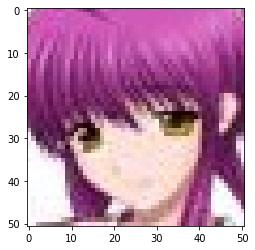

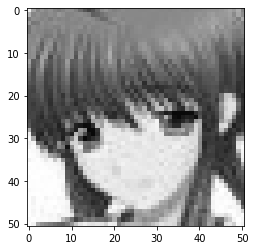

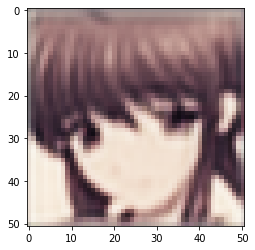

In [30]:
# Let's display these images

img = mpimg.imread('original.png')
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread('grayscale.png')
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread('output.png')
imgplot = plt.imshow(img)
plt.show()